In [7]:
import os
import numpy as np
import pandas as pd
import transform

from math import gcd
from fractions import Fraction
from matplotlib import pyplot as plt

figdir = '../../figure/digital-signal-synthesis'

cmap = plt.get_cmap('tab20c')

os.makedirs(figdir, exist_ok=True)

In [2]:
# accumulator bits
N = 8

# clock iterations
M = 50

# reference frequency
f_ref = 1e9

# output frequency
f_out = 1e8

# accumulator step
dphi = np.ceil(2**N * f_out / f_ref)

# accumulator values over one period
phi = np.cumsum(dphi * np.ones(M)).astype(np.uint8)

# accumulator iterations
n = 2**N * np.linspace(0, 1, M)

# output signal
s = np.cos(2*np.pi*phi / 2**N)

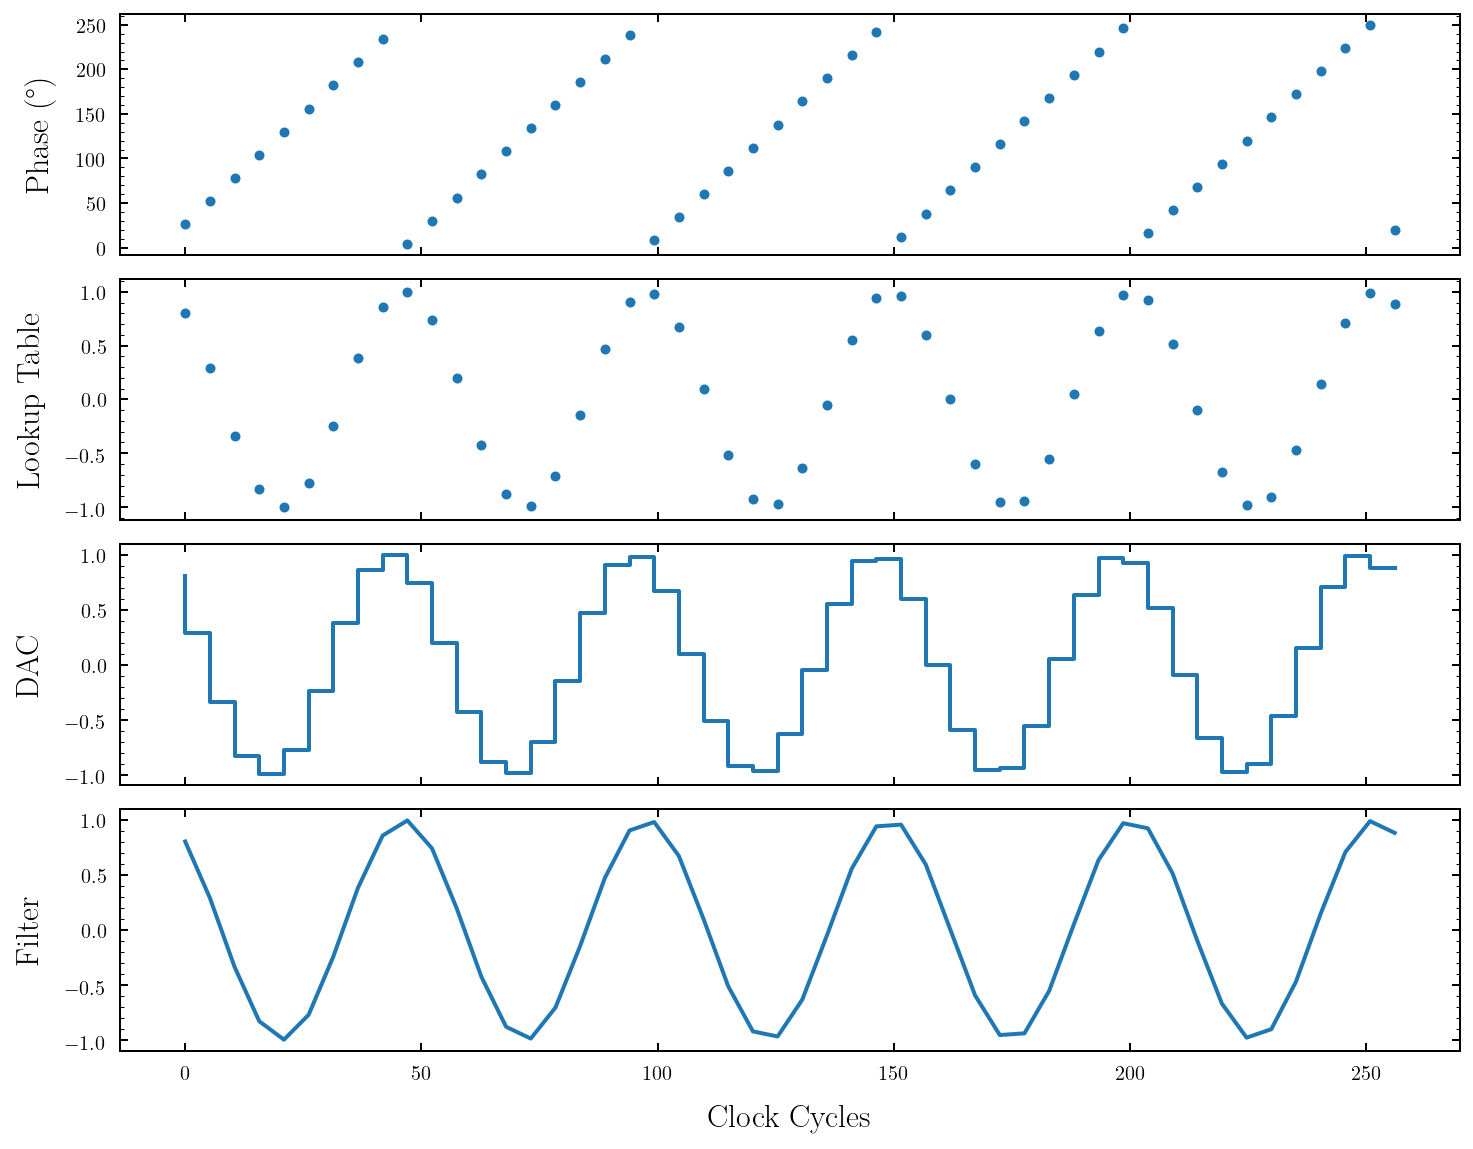

In [38]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(12, 8))

axes[0].scatter(n, phi)
axes[0].set_ylabel('Phase (\si{\degree})')

axes[1].scatter(n, s)
axes[1].set_ylabel('Lookup Table')

axes[2].step(n, s)
axes[2].set_ylabel('DAC')

axes[3].plot(n, s)
axes[3].set_ylabel('Filter')
axes[3].set_xlabel('Clock Cycles')

plt.subplots_adjust(hspace=.1, top=.98, bottom=.08)
plt.savefig(os.path.join(figdir, 'simple-output.pdf'))
plt.savefig(os.path.join(figdir, 'simple-output.pgf'))
plt.show()

In [3]:
dphi_250 = np.ceil(250 * f_out / f_ref)
dphi_256 = np.ceil(256 * f_out / f_ref)

sys_iter = 300

phi_250 = np.cumsum(dphi_250 * np.ones(sys_iter)).astype(np.uint8)
phi_256 = np.cumsum(dphi_256 * np.ones(sys_iter)).astype(np.uint8)

phi_err = phi_256-phi_250

m = np.arange(len(phi_err))

out_250 = np.cos(2*np.pi*phi_250 / 250)
out_256 = np.cos(2*np.pi*phi_256 / 256)

f_250, pd_250 = transform.fft(m / f_ref, out_250)
f_256, pd_256 = transform.fft(m / f_ref, out_256)

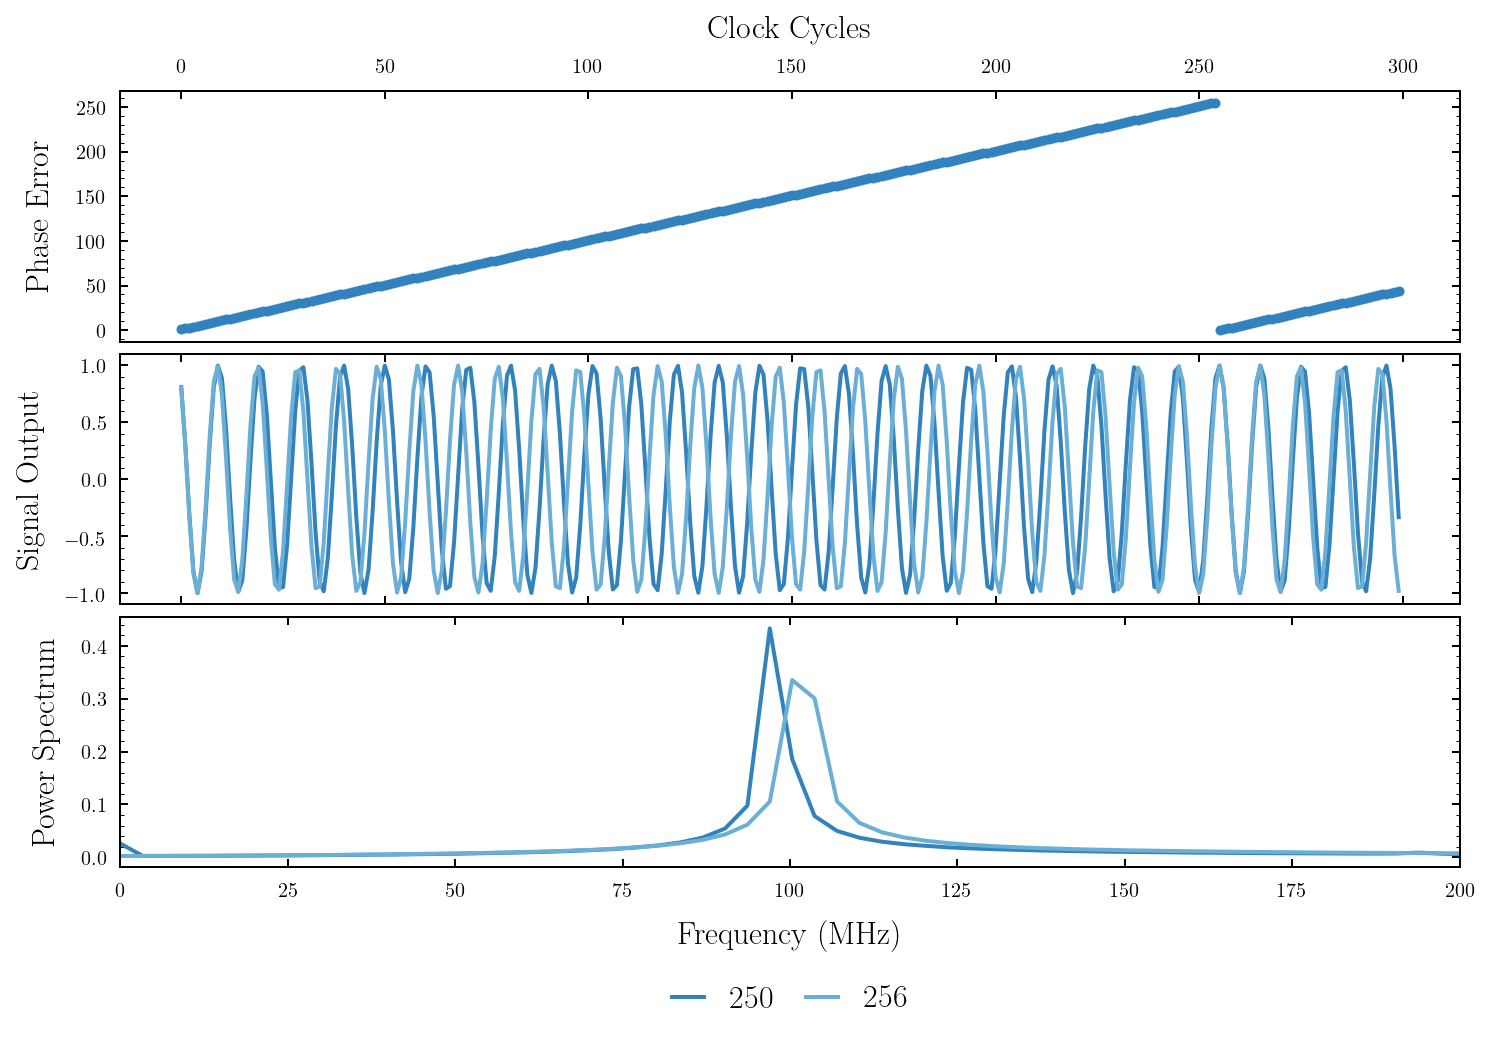

In [71]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 7))

axes[0].scatter(m, phi_err, color=cmap.colors[0])
axes[0].set_ylabel('Phase Error')
axes[0].set_xlabel('Clock Cycles')

axes[1].plot(out_250, label='250', color=cmap.colors[0])
axes[1].plot(out_256, label='256', color=cmap.colors[1])
axes[1].set_ylabel('Signal Output')

axes[0].get_shared_x_axes().join(axes[0], axes[1])
axes[1].set_xticklabels([])
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

axes[2].plot(f_250 / 1e6, pd_250, color=cmap.colors[0], label='250')
axes[2].plot(f_256 / 1e6, pd_256, color=cmap.colors[1], label='256')
axes[2].set_xlabel('Frequency (\si{\mega\hertz})')
axes[2].set_ylabel('Power Spectrum')
axes[2].set_xlim(0, 200)
axes[2].legend(loc='upper center', bbox_to_anchor=(.5, -0.35), ncol=2)

plt.subplots_adjust(hspace=.05, top=.92, bottom=.15)
plt.savefig(os.path.join(figdir, 'phase-error.pdf'))
plt.savefig(os.path.join(figdir, 'phase-error.pgf'))
plt.show()

In [4]:
f_1 = np.linspace(0, f_ref / 2, 300)
f_2 = np.linspace(0.08 * f_ref, 0.12 * f_ref, 300)

H_1 = np.sinc(f_1 / f_ref)**2
H_2 = np.sinc(f_2 / f_ref)**2

H_lin = np.poly1d(np.polyfit(f_2, H_2, 2))

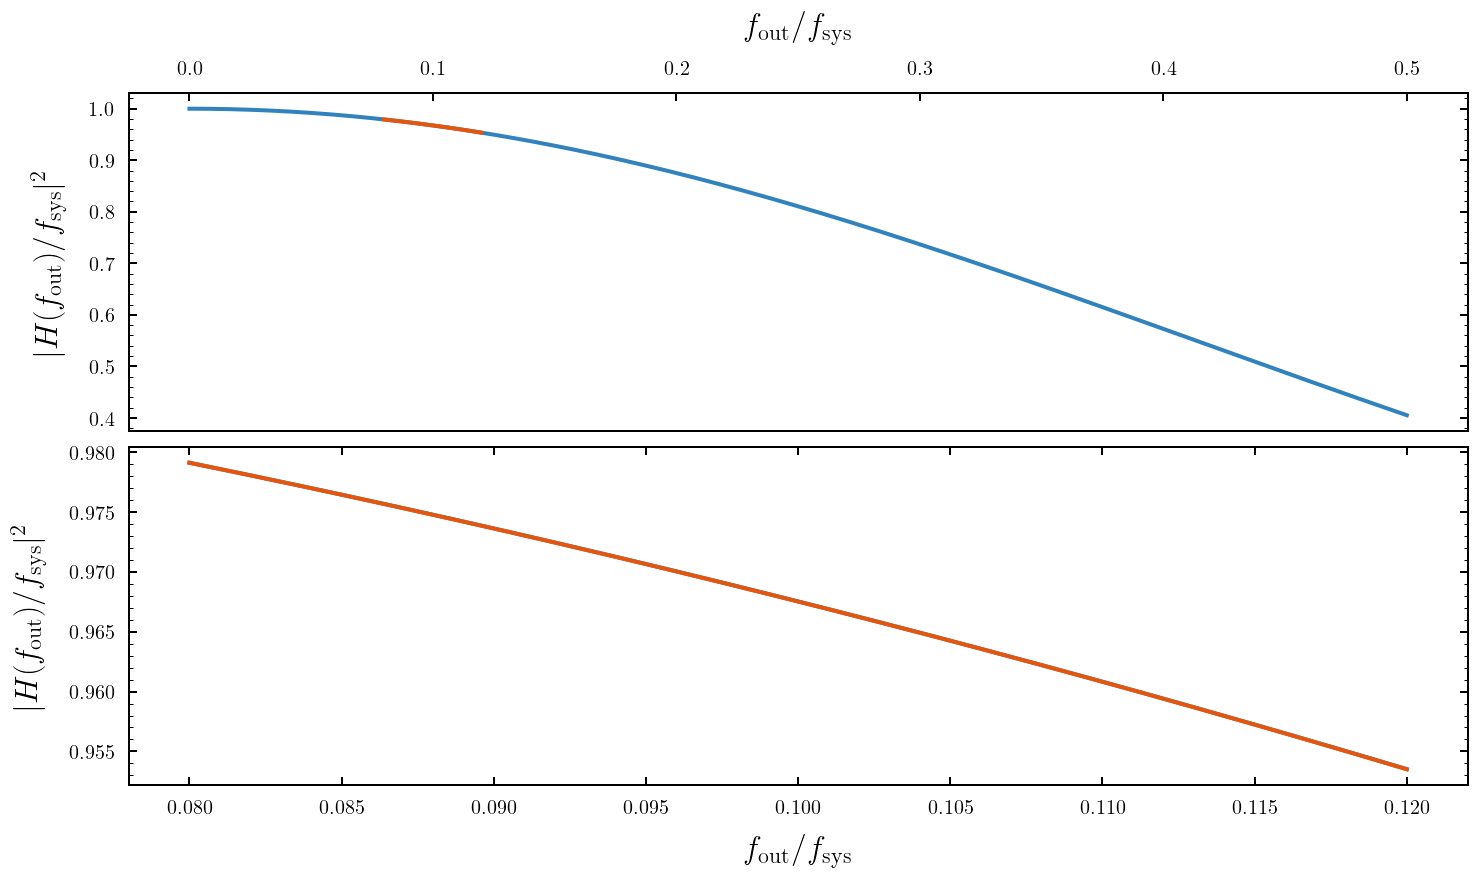

In [103]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))

axes[0].plot(f_1 / f_ref, H_1, color=cmap.colors[0])
axes[0].plot(f_2 / f_ref, H_lin(f_2), color=cmap.colors[4])
axes[0].set_xlabel(r'$f_\text{out}/f_\text{sys}$')
axes[0].set_ylabel(r'$\vert H(f_\text{out})/f_\text{sys}\vert^2$')
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

axes[1].plot(f_2 / f_ref, H_2, color=cmap.colors[0])
axes[1].plot(f_2 / f_ref, H_lin(f_2), color=cmap.colors[4])
axes[1].set_xlabel(r'$f_\text{out}/f_\text{sys}$')
axes[1].set_ylabel(r'$\vert H(f_\text{out})/f_\text{sys}\vert^2$')

plt.subplots_adjust(hspace=.05, top=.90, bottom=.10)
plt.savefig(os.path.join(figdir, 'response.pdf'))
plt.savefig(os.path.join(figdir, 'response.pgf'))
plt.show()

In [8]:
z = H_lin(f_2)
z.max() - z.min()

0.025617392536638528

In [9]:
P = np.arange(1, 2**16+1)
dt = 4 * P / f_ref

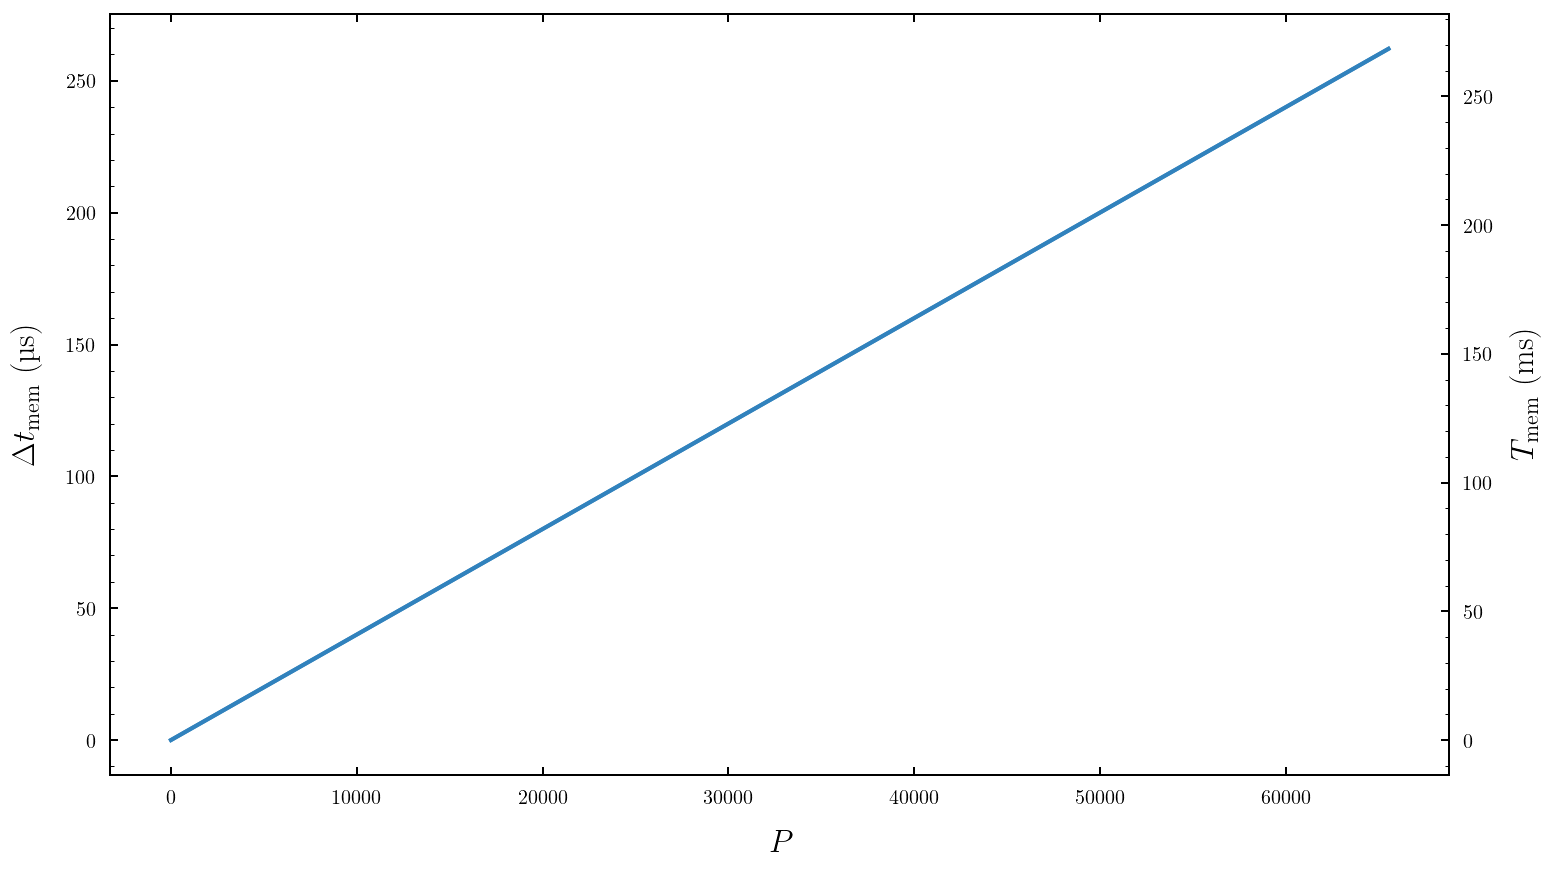

In [117]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(P, dt / 1e-6, color=cmap.colors[0])
ax1.set_xlabel(r'$P$')
ax1.set_ylabel(r'$\Delta t_\text{mem}$ (\si{\micro\second})')

ax2 = ax1.twinx()
ax2.plot(P, 1024 * dt / 1e-3, color=cmap.colors[0])
ax2.set_ylabel(r'$T_\text{mem}$ (\si{\milli\second})')

plt.subplots_adjust(hspace=.05, top=.98, bottom=.10)
plt.savefig(os.path.join(figdir, 'playback-rate.pdf'))
plt.savefig(os.path.join(figdir, 'playback-rate.pgf'))
plt.show()

In [11]:
f_start = 80e6
f_final = 120e6

L = np.ceil(2**32 * f_start / f_ref)
U = np.ceil(2**32 * f_final / f_ref)

R_max = 2**16 + 1
S_max = 2**32 + 1

N = 1024

T_ramp = 4*(U-L) / f_ref
T_mem = N * 4*(2**16) / f_ref 



GCD = gcd(N, int(U-L))

In [12]:
r = np.arange(1, np.floor(2**16 / (N/GCD)))
r

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [13]:
R = (N / GCD) * r
R

array([  256.,   512.,   768.,  1024.,  1280.,  1536.,  1792.,  2048.,
        2304.,  2560.,  2816.,  3072.,  3328.,  3584.,  3840.,  4096.,
        4352.,  4608.,  4864.,  5120.,  5376.,  5632.,  5888.,  6144.,
        6400.,  6656.,  6912.,  7168.,  7424.,  7680.,  7936.,  8192.,
        8448.,  8704.,  8960.,  9216.,  9472.,  9728.,  9984., 10240.,
       10496., 10752., 11008., 11264., 11520., 11776., 12032., 12288.,
       12544., 12800., 13056., 13312., 13568., 13824., 14080., 14336.,
       14592., 14848., 15104., 15360., 15616., 15872., 16128., 16384.,
       16640., 16896., 17152., 17408., 17664., 17920., 18176., 18432.,
       18688., 18944., 19200., 19456., 19712., 19968., 20224., 20480.,
       20736., 20992., 21248., 21504., 21760., 22016., 22272., 22528.,
       22784., 23040., 23296., 23552., 23808., 24064., 24320., 24576.,
       24832., 25088., 25344., 25600., 25856., 26112., 26368., 26624.,
       26880., 27136., 27392., 27648., 27904., 28160., 28416., 28672.,
      

In [75]:
PS = (U-L) / GCD * r
PS

array([4.29496730e+07, 8.58993460e+07, 1.28849019e+08, 1.71798692e+08,
       2.14748365e+08, 2.57698038e+08, 3.00647711e+08, 3.43597384e+08,
       3.86547057e+08, 4.29496730e+08, 4.72446403e+08, 5.15396076e+08,
       5.58345749e+08, 6.01295422e+08, 6.44245095e+08, 6.87194768e+08,
       7.30144441e+08, 7.73094114e+08, 8.16043787e+08, 8.58993460e+08,
       9.01943133e+08, 9.44892806e+08, 9.87842479e+08, 1.03079215e+09,
       1.07374182e+09, 1.11669150e+09, 1.15964117e+09, 1.20259084e+09,
       1.24554052e+09, 1.28849019e+09, 1.33143986e+09, 1.37438954e+09,
       1.41733921e+09, 1.46028888e+09, 1.50323856e+09, 1.54618823e+09,
       1.58913790e+09, 1.63208757e+09, 1.67503725e+09, 1.71798692e+09,
       1.76093659e+09, 1.80388627e+09, 1.84683594e+09, 1.88978561e+09,
       1.93273528e+09, 1.97568496e+09, 2.01863463e+09, 2.06158430e+09,
       2.10453398e+09, 2.14748365e+09, 2.19043332e+09, 2.23338300e+09,
       2.27633267e+09, 2.31928234e+09, 2.36223202e+09, 2.40518169e+09,
      

In [80]:
P = np.arange(1, 2**16)

In [81]:
S = np.outer(PS, 1/P)

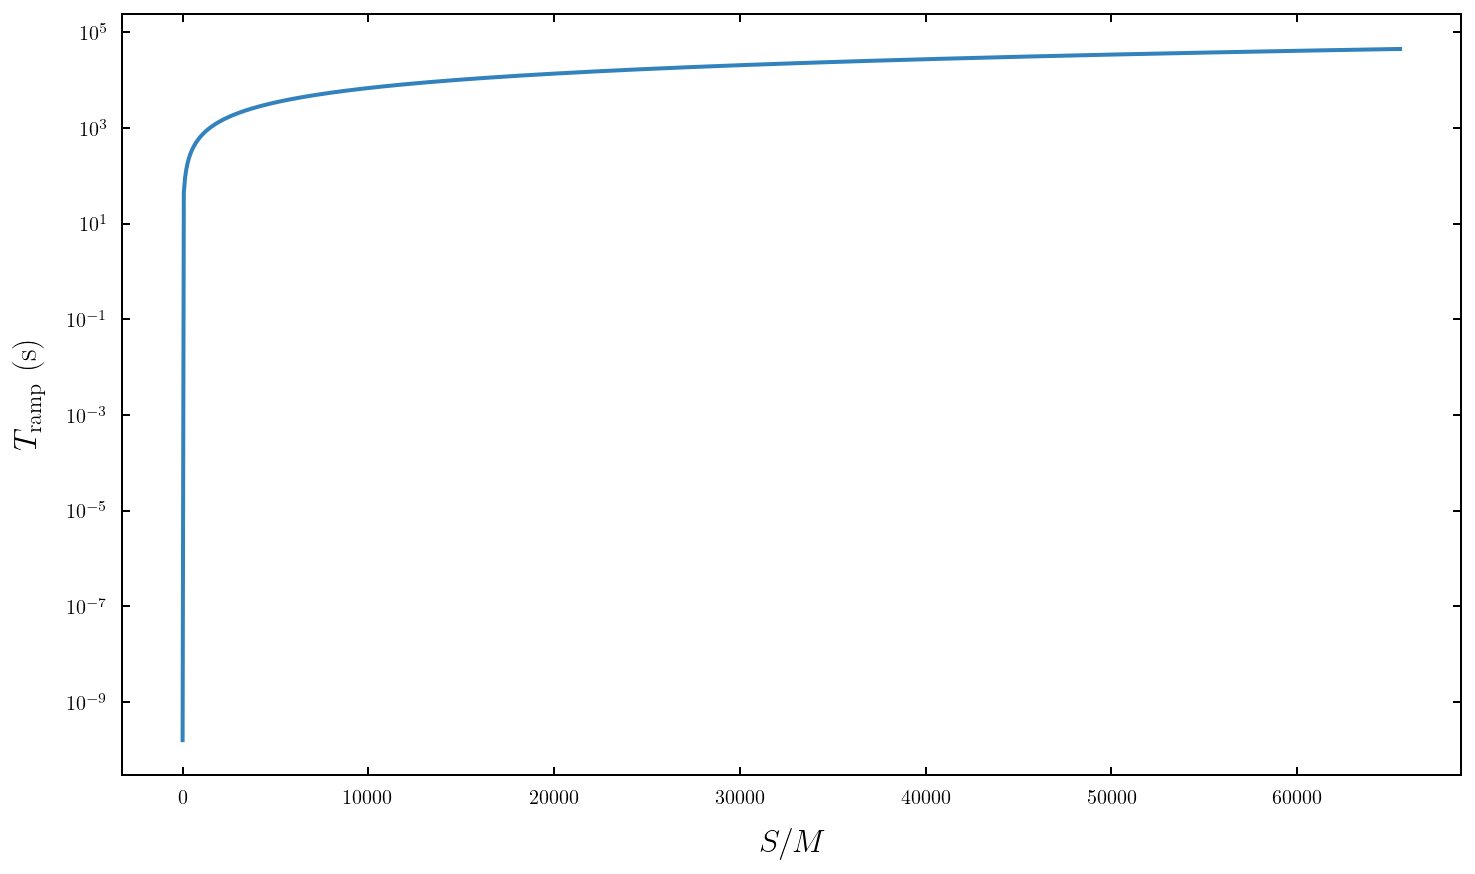

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(SM, T, color=cmap.colors[0])
ax1.set_xlabel(r'$S/M$')
ax1.set_ylabel(r'$T_\text{ramp}$ (\si{\second})')
ax1.set_yscale('log')
#ax2 = ax1.twinx()
#ax2.plot(P, 1024 * dt / 1e-3, color=cmap.colors[0])
#ax2.set_ylabel(r'$T_\text{mem}$ (\si{\milli\second})')

plt.subplots_adjust(hspace=.05, top=.98, bottom=.10)
#plt.savefig(os.path.join(figdir, 'playback-rate.pdf'))
#plt.savefig(os.path.join(figdir, 'playback-rate.pgf'))
plt.show()

In [14]:
T.min(), T.max()

(0.0, 45036.683510416)

In [15]:
from fractions import Fraction

N = 1024
T = 4 * N * np.arange(1, 2**16) / f_ref

RS = T * f_ref / 4 / (U-L)

R = []
S = []

for rs in RS:
    frac = Fraction.from_float(rs).limit_denominator(2**32)
    
    if rs > 1:
        frac = frac.limit_denominator(2**16)
        
    R.append(frac.numerator)
    S.append(frac.denominator)
        
R = np.array(R)
S = np.array(S)

FN = np.round((U-L) / S)

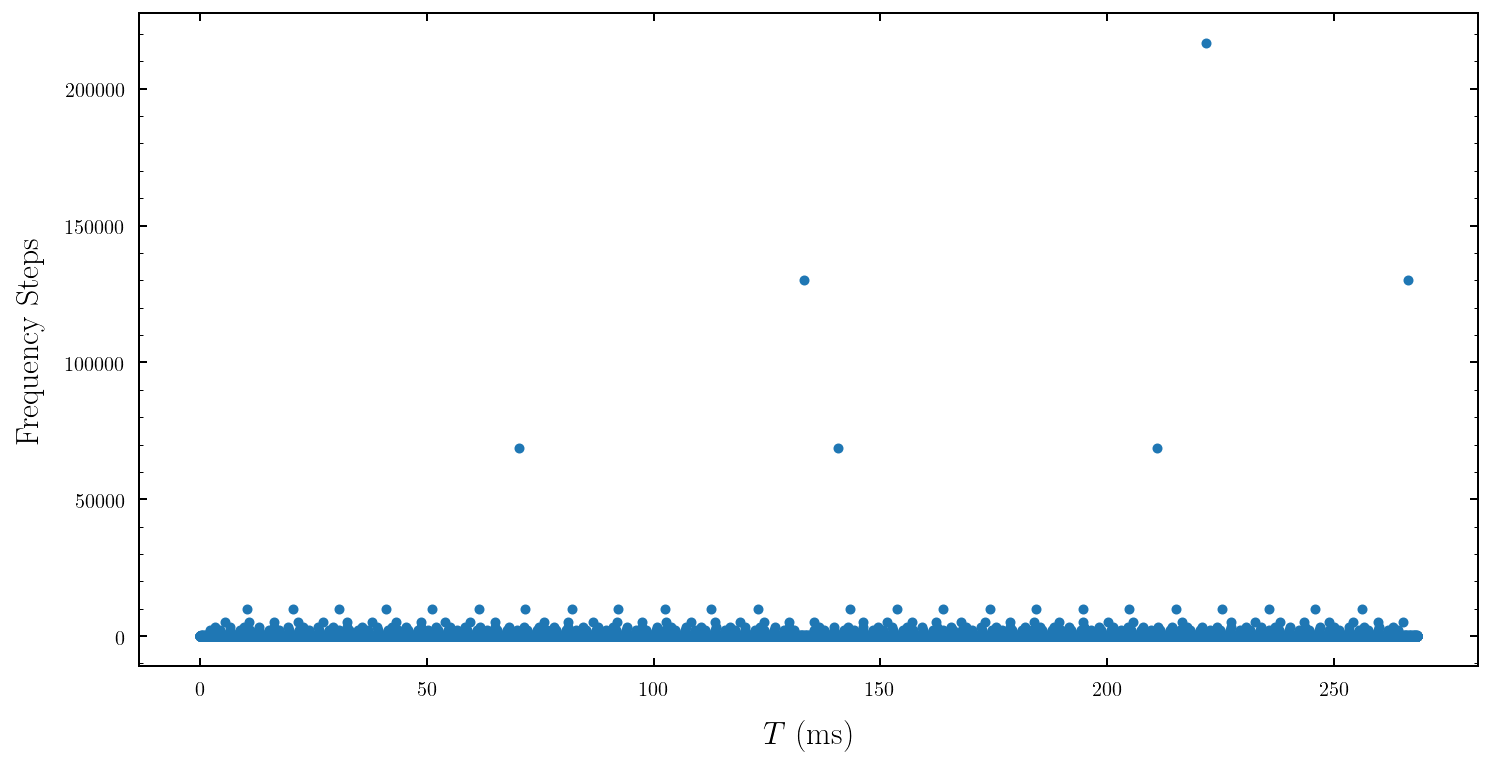

In [139]:
plt.figure(figsize=(12, 6))
plt.scatter(T / 1e-3, FN)
#plt.yscale('log')
#plt.ylim(0, 10)
plt.xlabel(r'$T$ (\si{\milli\second})')
plt.ylabel(r'Frequency Steps')
plt.show()

In [167]:
values = np.unique(FN)
counts = [np.sum(FN == v) for v in values]

values, counts

(array([0.00000e+00, 4.00000e+00, 5.20000e+01, 1.64000e+02, 2.44000e+02,
        2.13200e+03, 3.17200e+03, 5.28400e+03, 1.00040e+04, 6.86920e+04,
        1.30052e+05, 2.16644e+05]),
 [3731, 54429, 4681, 1451, 968, 120, 80, 45, 24, 3, 2, 1])

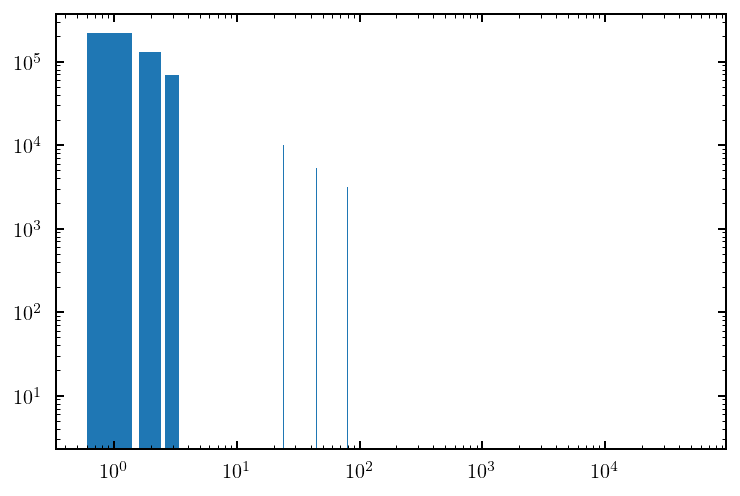

In [168]:
plt.bar(counts, values)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [142]:
FN.min(), FN.max(), FN.mean()

(0.0, 216644.0, 39.75866330968185)

In [169]:
T[0], T[-1]

(4.096e-06, 0.26843136)

In [175]:
FN[0], FN[-5:]

(4.0, array([ 0.,  0., 52.,  4.,  4.]))

In [179]:
(U-L)/Fraction(2**16/(U-L)).limit_denominator(2**32).denominator

4.0

In [228]:
i = np.abs(T - 260e-3).argmin()

P[i], T[i], R[i], S[i], S[i] * f_ref / 2**32, 4*R[i] / f_ref, R[i] / S[i]

(63477,
 0.260001792,
 16250112,
 42949673,
 10000000.009313226,
 0.065000448,
 0.37835240328837894)

In [226]:
i = np.abs(T - 30e-3).argmin()

P[i], T[i], R[i], S[i], S[i] * f_ref / 2**32, 4*R[i] / f_ref

(7324, 0.029999104, 1874944, 42949673, 10000000.009313226, 0.007499776)

In [200]:
i = np.abs(FN - 2132).argmin()

P[i], T[i], R[i], S[i], R[i] / S[i], (U-L) / S[i]

(533, 0.002183168, 256, 80581, 0.003176927563569576, 2132.0)

In [198]:
values

array([0.00000e+00, 4.00000e+00, 5.20000e+01, 1.64000e+02, 2.44000e+02,
       2.13200e+03, 3.17200e+03, 5.28400e+03, 1.00040e+04, 6.86920e+04,
       1.30052e+05, 2.16644e+05])

In [223]:
i = np.abs(T - T[FN == 68692].max()).argmin()

P[i], T[i], R[i], S[i], R[i] / S[i], (U-L) / S[i], T[i] / 

(51519, 0.211021824, 768, 2501, 0.30707716913234706, 68692.0)

In [18]:
i = np.abs(T - 260e-3).argmin()

T_ramp = T[i]

f_step = S[i] * f_ref / 2**32
t_step = 4 * R[i] / f_ref

t_ramp = T_ramp * np.linspace(0, 1, 100)
f_ramp = 80e6 + 40e6 * t_ramp / T_ramp

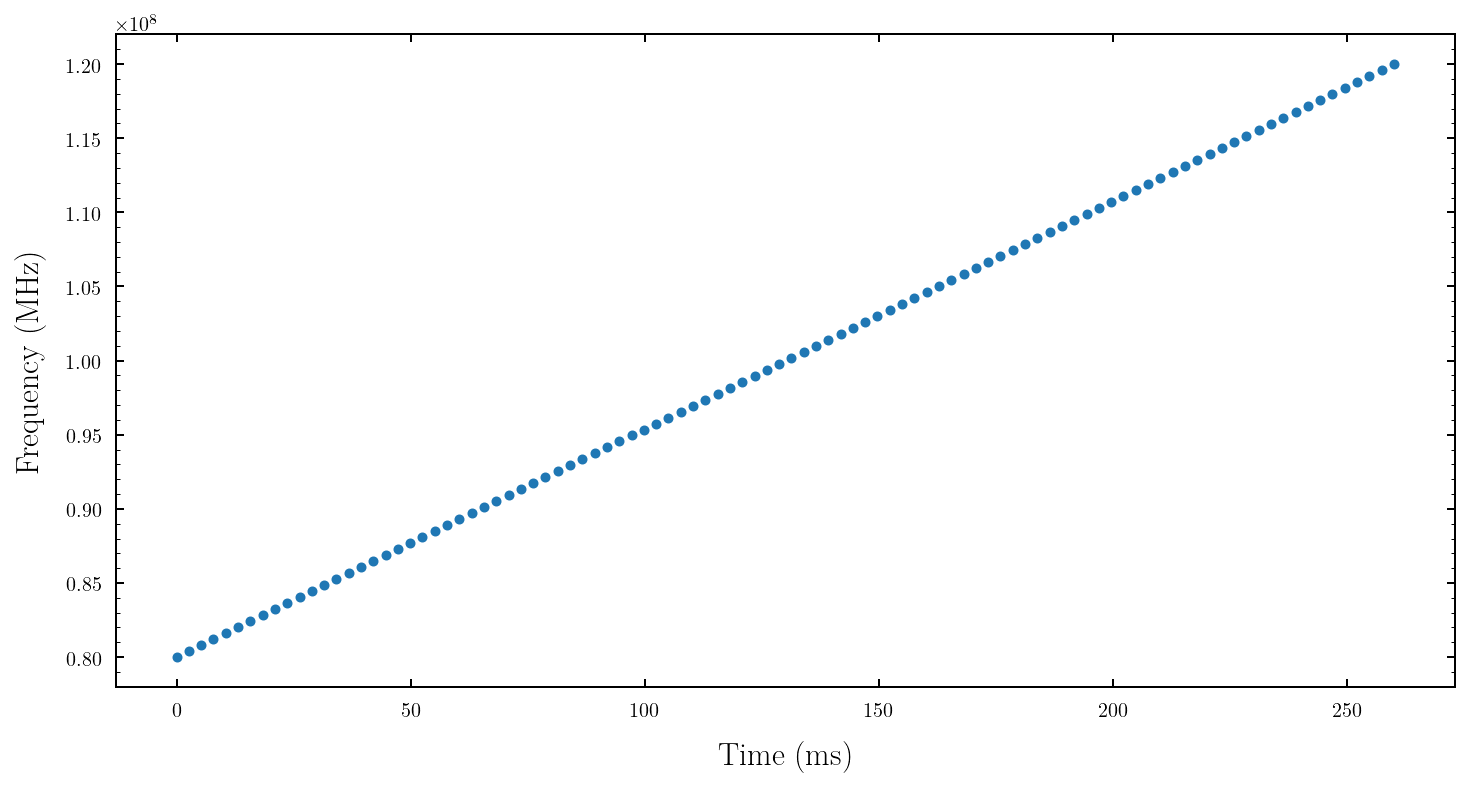

In [19]:
plt.figure(figsize=(12, 6))
plt.scatter(t_ramp / 1e-3, f_ramp / 1)
#plt.yscale('log')
#plt.ylim(0, 10)
plt.xlabel(r'Time (\si{\milli\second})')
plt.ylabel(r'Frequency (\si{\mega\hertz})')
plt.show()

In [20]:
4*(U-L) / f_ref

0.687194768

In [21]:
4*T_ramp / f_ref

1.0400071680000001e-09